# Probability Estimation and Calibration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from venn_abers import VennAbersCalibrator

# https://github.com/classifier-calibration/PyCalib/blob/master/examples/xmpl_quickstart.py
from pycalib.metrics import conf_ECE
from pycalib.visualisations import plot_reliability_diagram
# from pycalib.models import CalibratedModel

from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.utils import check_random_state
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

<div align="justify">

The predictions delivered by corresponding methods are at best "pseudo-probabilities" that are often not very accurate. 
Besides, there are many methods that deliver natural scores, 
intuitively expressing a degree of confidence 
(like the distance from the [separating hyperplane in support vector machines](svm)), 
but which do not immediately qualify as probabilities either. 
The idea of *scaling* or *calibration methods* is to turn such scores into proper, 
well-calibrated probabilities, that is, 
to learn a mapping from scores to the unit interval that can be applied to the output of a predictor as a kind of post-processing step ({cite:t}`flac_cc17`). 
Examples of such methods include binning ({cite:t}`zadr_oc01`), 
isotonic regression ({cite:t}`zadr_tc02`), 
logistic scaling ({cite:t}`Pla00`) 
and improvements thereof ({cite:t}`kull_bc17`), 
as well as the use of Venn predictors ({cite:t}`joha_vp18`). 
Calibration is still a topic of ongoing research. 

</div>

(svm)=
## Separating Hyperplane in Support Vector Machines

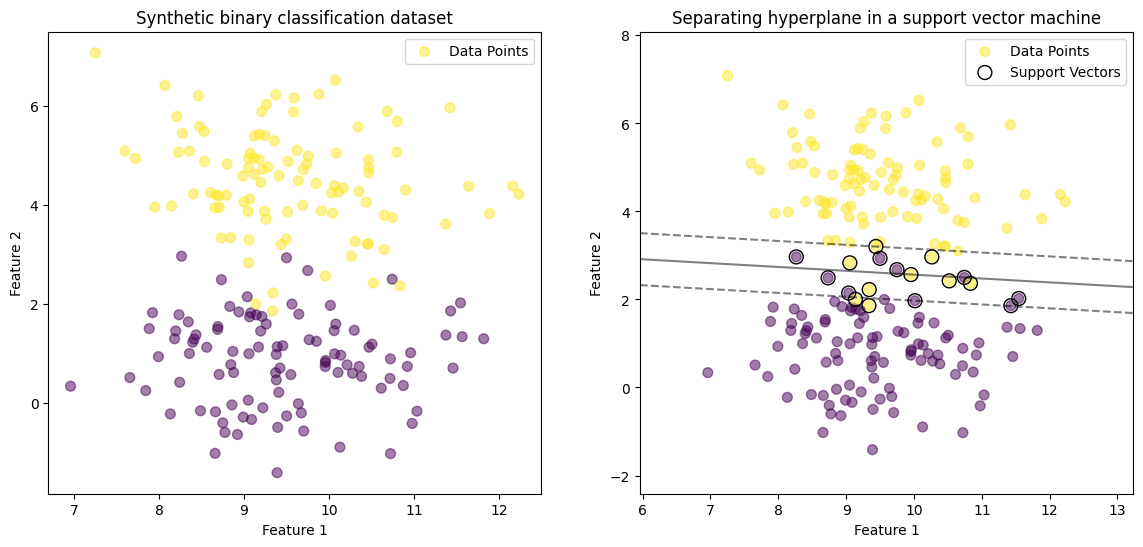

In [2]:
X, y = make_blobs(n_samples=200, centers=2, random_state=4)

clf = SVC(kernel="linear", C=1000)
clf.fit(X, y)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 6))

ax0.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', alpha=0.5)
ax0.set_title('Synthetic binary classification dataset')
ax0.legend(['Data Points'])
ax0.set_xlabel('Feature 1')
ax0.set_ylabel('Feature 2')

ax1.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', alpha=0.5)
ax1.set_title('Separating hyperplane in a support vector machine')
DecisionBoundaryDisplay.from_estimator(clf, X, plot_method="contour", colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"], ax=ax1)
ax1.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100, linewidth=1, facecolors="none", edgecolors="k")
ax1.legend(('Data Points', 'Support Vectors')) # , loc="lower right"
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

plt.show()

### logistic scaling 

<div align="justify">

 Introduced by {cite:t}`Pla00`, logistic (Platt) scaling was originally a method for calibrating support vector machines. 
 It works by finding the parameters of a sigmoid function maximizing the likelihood of the training set. 
 We here apply a [logistic regression model](logistic) to the outputs of the SVM classifier, 
 transforming the raw scores of the SVM into calibrated probabilities.

</div>


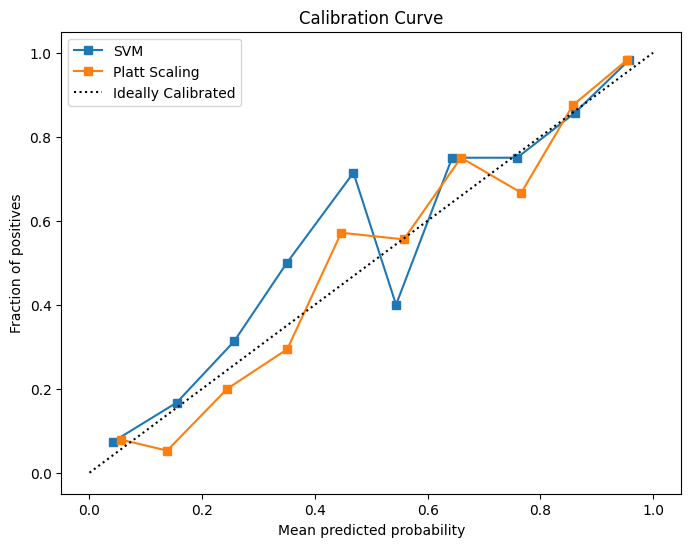

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)
raw_outputs = svm.decision_function(X_test)

platt_model = LogisticRegression()
platt_model.fit(raw_outputs.reshape(-1, 1), y_test)
platt_probs = platt_model.predict_proba(raw_outputs.reshape(-1, 1))[:, 1]
svm_probs = svm.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, svm_probs, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="SVM")

fraction_of_positives_platt, mean_predicted_value_platt = calibration_curve(y_test, platt_probs, n_bins=10)

plt.plot(mean_predicted_value_platt, fraction_of_positives_platt, "s-", label="Platt Scaling")
plt.plot([0, 1], [0, 1], "k:", label="Ideally Calibrated")

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()

In [4]:
brier_svm = brier_score_loss(y_test, svm_probs)
brier_platt = brier_score_loss(y_test, platt_probs)

print(f"Brier score (SVM): {brier_svm:.4f}")
print(f"Brier score (Platt Scaling): {brier_platt:.4f}")

Brier score (SVM): 0.0625
Brier score (Platt Scaling): 0.0496


<div align="justify">

The Brier scores indicate that Platt scaling has slightly improved the calibration of the SVM probabilities, as reflected in the lower Brier score for Platt scaling compared to the raw SVM probabilities.

</div>

### binning

<div align="justify">

Binning assigns the same probability estimate to all examples in each bin, 
the ranking of examples inside bins is lost. 
The number of different probability estimates that binning can yield is limited by the number of alternative bins.

Binning reduces the resolution, i.e. the degree of detail, 
of conditional probability estimates, 
while improving the accuracy of these estimates by reducing both variance and bias compared to uncalibrated estimates. 

If the shape of the mapping function is unknown, we can resort to a non-parametric method such as binning. 
In binning, the training examples are sorted according to their scores and the sorted set is divided into $b$ subsets of equal size, called bins. 

For each bin, we compute lower and upper boundary $s(\cdot)$ scores. 
Given a test example $x$, we place it in a bin according to its score $s(x)$. 
We then estimate the corrected probability that $x$ belongs to class $c$ as the fraction of training examples in the bin that actually belong to $c$. 

({cite:t}`zadrozny_learning_2001,zadr_oc01`)

</div>

### Isotonic Regression

<div align="justify">

A difficulty of the binning method is that we have to choose the number of bins by cross-validation. 
If the dataset is small, or highly unbalanced, cross-validation is not likely to indicate the optimal number of bins. 
Also, the size of the bins is fixed and the position of the boundaries is chosen arbitrarily. 
If the boundaries are such that we average together the labels of examples that clearly should have different probability estimates, 
the binning method will fail to produce accurate probability estimates.

Isotonic regression, 
an intermediary approach between sigmoid fitting and binning, 
is a non-parametric form of regression in which we assume that the function is chosen from the class of all isotonic (i.e. non-decreasing) functions.

If we assume that the classifier ranks examples correctly, 
the mapping from scores into probabilities is non-decreasing, 
and we can use isotonic regression to learn this mapping. 
A commonly used algorithm for computing the isotonic regression is pair-adjacent violators (PAV) ({cite:t}`ayer_empirical_1955`). 
This algorithm finds the stepwise-constant isotonic function that best fits the data according to a mean-squared error criterion ({cite:t}`zadr_tc02`).

Based on the [previous chapter](../chapter-pe-scoring/scoring), 
we utilize the Isotonic Regression for a comparison on the same dataset.

</div>

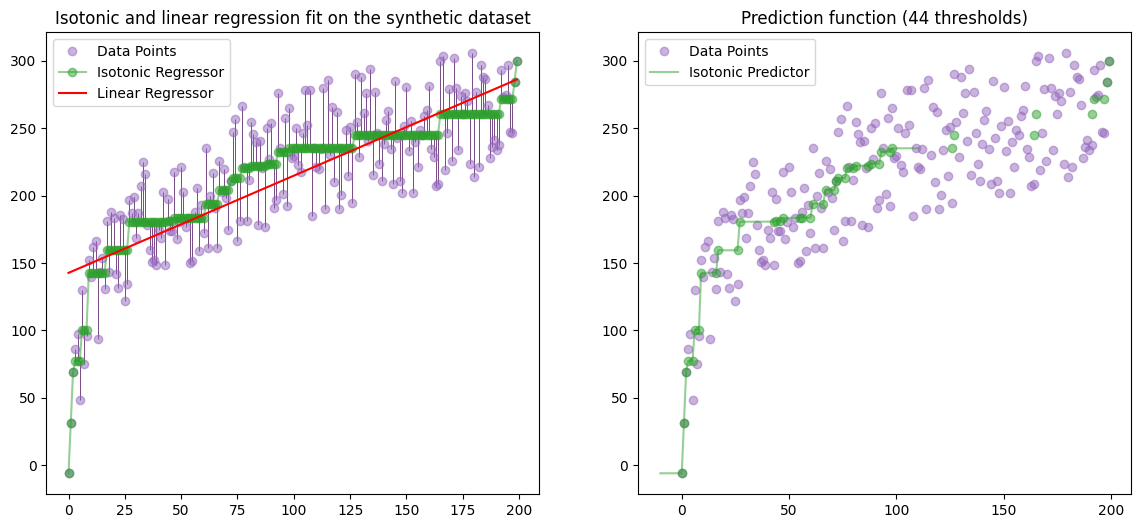

In [5]:
n = 200
X = np.arange(n)
rs = check_random_state(0)
y = rs.randint(-50, 50, size=(n,)) + 50.0 * np.log1p(np.arange(n))

lr = LinearRegression()
lr.fit(X[:, np.newaxis], y)

ir = IsotonicRegression(out_of_bounds="clip")
y_ = ir.fit_transform(X, y)

segments = [[[i, y[i]], [i, y_[i]]] for i in range(n)]
lc = LineCollection(segments, zorder=0)
lc.set_array(np.ones(len(y)))
lc.set_linewidths(np.full(n, 0.5))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 6))

ax0.plot(X, y, "C4.", alpha=0.5, markersize=12)
ax0.plot(X, y_, "C2.-", alpha=0.5, markersize=12)
ax0.plot(X, lr.predict(X[:, np.newaxis]), 'red') 
ax0.add_collection(lc)
ax0.legend(("Data Points", "Isotonic Regressor", "Linear Regressor")) # , loc="upper left" , 'lower right'
ax0.set_title("Isotonic and linear regression fit on the synthetic dataset")

x_test = np.linspace(-10, 110, 1000)
ax1.plot(X, y, "C4.", alpha=0.5, markersize=12)
ax1.plot(x_test, ir.predict(x_test), "C2-", alpha=0.5) 
ax1.plot(ir.X_thresholds_, ir.y_thresholds_, "C2.", alpha=0.5, markersize=12)
ax1.legend(("Data Points", "Isotonic Predictor"))
ax1.set_title("Prediction function (%d thresholds)" % len(ir.X_thresholds_))

plt.show()

### Venn predictors

<div align="justify">

Introduced by {cite:t}`vovk_self_2003`, 
Venn predictors are multi-probabilistic predictors with proven validity properties. 
The impossibility result described earlier for probabilistic prediction is circumvented in two ways: 
1. multiple probabilities for each label are outputted, with one of them being the valid one; 
1. the statistical tests for validity are restricted to calibration. 
More specifically, the probabilities must be matched by observed frequencies. 
As an example, if we make a number of probabilistic predictions with the probability estimate 0.9 these predictions should be correct in about 90% of the cases.

</div>

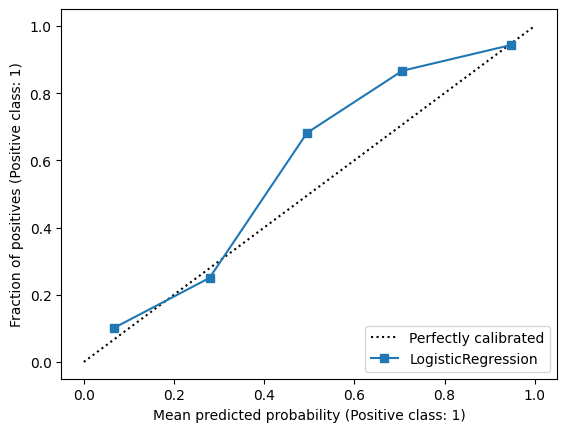

In [6]:
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)
p_pred = lr.predict_proba(X_test)[:, 1]

disp = CalibrationDisplay.from_estimator(lr, X_test, y_test)
plt.show()

# vac = VennAbersCalibrator()
# vac.fit(X_train, y_train)
# vac_pred = vac.predict_proba(X_test)

# loss = log_loss(y_test, vac_pred[:, 1])
# accuracy = accuracy_score(y_test, np.round(vac_pred[:, 1]))
# brier_score = brier_score_loss(y_test, vac_pred[:, 1])
# aucroc_score = roc_auc_score(y_test, vac_pred[:, 1])

# print(f"Log Loss: {loss:.4f}")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Brier Score: {brier_score:.4f}")
# print(f"AUC-ROC Score: {aucroc_score:.4f}")

<div align="justify">

```{note}
Venn predictors are related to the more well-known Conformal Prediction (CP) framework, 
which was introduced as an approach for associating predictions with confidence measures ({cite:t}`saunders_transduction_1999`). 
```

</div>

## Classifier Calibration

<div align="justify">

The aim of calibration in binary classification is to take an uncalibrated scoring classifier $s=f(x)$ and apply a calibration map $\mu$ on top of it to produce calibrated probabilities $\mu(f(x))$. 
Formally, a scoring classifier is perfectly calibrated on a dataset if for each of its output scores $s$ the proportion of positives within instances with model output score $s$ is equal to $s$. 
Denoting the instances in the dataset by $\vec{x}_1, \cdots, \vec{x}_n$ and their binary labels by $y_1, \cdots, y_n$, 
a model $f$ is calibrated on this dataset if for each of its possible outputs $s_i = f(x_i)$ the following holds:

$$
s_i = \mathbb{E}[Y\vert f(X)=s_i],
$$

where the random variables $X$, $Y$ denote respectively the features and label of a uniformly randomly drawn instance from the dataset, 
where the labels $Y = 1$ and $Y = 0$ stand for a positive and negative, respectively. 
This expectation can be rewritten as follows: 

$$
\mathbb{E}[Y\vert f(X)=s_i] = \frac{\sum_{j=1}^n y_j \cdot I[f(x_j)=s_i]}{\sum_{j=1}^n I[f(x_j)=s_i]},
$$

where $I[\cdot]$ is the indicator function. 
For any fixed model $f$ there exists a uniquely determined calibration map which produces perfectly calibrated probabilities on the given dataset. 
That calibration map can be defined as $\mu(s_i) = \mathbb{E}[Y\vert f(X)=s_i]$. 
However, usually we do not want to learn perfect calibration maps on the training data, 
because these would overfit and would be far from being calibrated on the test data. 

({cite:t}`kull_bc17`)

</div>

<div align="justify">

```{note}
A lower Brier loss, for instance, does not necessarily mean a better calibrated model, 
it could also mean a worse calibrated model with much more discriminatory power, 
e.g., using many more features.
```

</div>

https://scikit-learn.org/stable/modules/calibration.html

https://arxiv.org/pdf/2112.10327

({cite:t}`silva_classifier_2023`) 